### 합성곱 신경망

#### 개요

- 시각적 영상을 분석하는 데 사용되는 다층의 피드-포워드적인 인공신경망의 한 종류.

#### 합성곱 연산과정

- 합성곱 신경망에서는 하나의 함수가 다른 함수와 얼마나 일치하는가의 의미로 사용됩니다. 필터(커널)가 이미지를 쭉 지나가면서 이미지의 부분 부분이 필터와 얼마나 일치하는지 계산합니다.

<img src="https://camo.githubusercontent.com/efb41f946b8ab6be31ac4145a5cca8ccb7a043205c68186fa71cf047bff6bfd0/68747470733a2f2f696d67312e6461756d63646e2e6e65742f7468756d622f523132383078302f3f73636f64653d6d746973746f72793226666e616d653d6874747073253341253246253246626c6f672e6b616b616f63646e2e6e6574253246646e25324662416b5843562532466274714a577248456e5a6c2532466c39474c686c654a544237335061746966676f4e4b6b253246696d672e706e67" width="700">

- 합성곱도 인공신경망의 하나
	- 단, 하나의 결괏값이 생성될 때 입력값 전체가 들어가지 않고 필터가 지나가는 부분만 연산에 포함된다는 점
	- 하나의 이미지에 같은 필터를 연달아 적용하기 때문에 가중치가 공유되어 기본 인공 신경망보다 학습의 대상이 되는 변수가 적다는 점이 차이점

- 비선형성을 추가하기 위해서는 활성화 함수가 필요. 자주 사용하는 함수로 렐루(ReLU) 함수 존재

##### ReLU
<img src="https://camo.githubusercontent.com/d85c70abfb695a06b96c81405449f802814723582c1d2d95244a879824760058/68747470733a2f2f7777772e68616e6269742e636f2e6b722f646174612f656469746f722f32303139303631393131333435335f6f77767a766466612e6a7067" width="700">

- 기본 렐루 함수
	- 단순히 0 이하의 값이 들어오면 활성화 값을 0으로 맞추고 그 이상의 값이 들어오면 값을 그대로 전달. 학습 속도가 빠른 장점이 있지만 어느 순간 큰 손실이 발생하여 가중치와 편차가 마이너스로 떨어지는 경우, 어떠한 입력이 들어와도 활성화 값이 0이 되는 다잉 뉴런(dying neuron) 이라는 현상 발생
- 리키 렐루 함수 & 랜덤 리키 렐루 함수
	- 이러한 문제를 해결하기 위해 나온 렐루의 변형된 형태로 리키 렐루와 랜덤 리키 렐루 등 존재. 리키 렐루는 상수 a에 작은 값을 설정함으로써 0 이하의 자극이 들어왔을 때도 활성화 값이 전달되게. 랜덤 리키 렐루는 a의 값을 랜덤하게 지정하는 활성화 함수.

#### 패딩과 풀링
- 입력 이미지에 필터를 한 번 적용할 때마다 켤과의 가로세로 크기가 줄어듬. 이렇게 해서 나온 것이 패딩(padding) 일정한 크기의 층으로 이미지를 감싸는 것
- 입력 이미지에서 충분한 특성을 뽑아내기 위함. 
- 입력 이미지가 너무 크면 엄청난 연산이 필요해 크기를 줄이는 것이 풀링(pooling) . 맥스 풀링과 평균 풀링

- 합성곱 연산을 하고 나면 활성화 함수를 통과하는 과정까지 몇 번 반복한 후 풀링을 적용. 세로x가로x채널을 한줄로 쭉 펴서 하나의 벡터가 생성됨

#### 소프트맥스 함수
- 신경망의 결과값을 확률로 바꿔줄 때 사용하는 방법. 
- 클래스를 구분하는 작업에 주로 교차 엔트로비 손실함수 사용

#### 모델 구현, 학습

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset # 데이터를 읽어오는 역할
import torchvision.transforms as transforms # 불러온 이미지를 필요에 따라 변환해주는 역할
from torch.utils.data import DataLoader # 데이터를 배치 사이즈대로 묶어서 전달하거나 정렬, 셔플 등을 해주는 역할

from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
## 하이퍼파라미터 / 배치사이즈, 학습비율, 에폭 횟수
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

##### 데이터셋 로드 및 데이터로더 설정
데이터, 배치사이즈, 셔플, 사용프로세스 수, 마지막 남은 데이터 처리여부

In [6]:
## MNIST 데이터셋 로드
mnist_train = dset.MNIST('./', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST('./', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

## DataLoader
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [7]:
mnist_train.__getitem__(0)[0].size(), mnist_train.__len__()

(torch.Size([1, 28, 28]), 60000)

In [8]:
mnist_test.__getitem__(0)[0].size(), mnist_test.__len__()

(torch.Size([1, 28, 28]), 10000)

In [9]:
len(mnist_train), len(mnist_test)

(60000, 10000)

- 합성곱 신경망 모델 메서드 생성

In [10]:
class CNN(nn.Module):
	def __init__(self) -> None:
		super().__init__()
		self.layer = nn.Sequential(
			nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  ## 커널사이즈 : 컨벌루젼 필터 크기 지정
			nn.ReLU(),
			nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2,stride=2),
			nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2,stride=2)
		)
		self.fc_layer = nn.Sequential(
			nn.Linear(64*3*3,512),                                              # [batch_size,64*3*3] -> [batch_size,100]
			nn.ReLU(),
			nn.Linear(512, 100),
			nn.ReLU(),
			nn.Linear(100,10)                                                   # [batch_size,100] -> [batch_size,10]
		)

	def forward(self, x):
		out = self.layer(x)
		out = out.view(batch_size, -1)

		out = self.fc_layer(out)
		return out

In [12]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = CNN().to(device)

# 손실함수로는 크로스엔트로피를 사용합니다.
loss_func = nn.CrossEntropyLoss()

# 최적화함수로는 Adam을 사용합니다.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


##### 학습

In [13]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2465, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0558, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0594, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward0>)


##### 손실값 

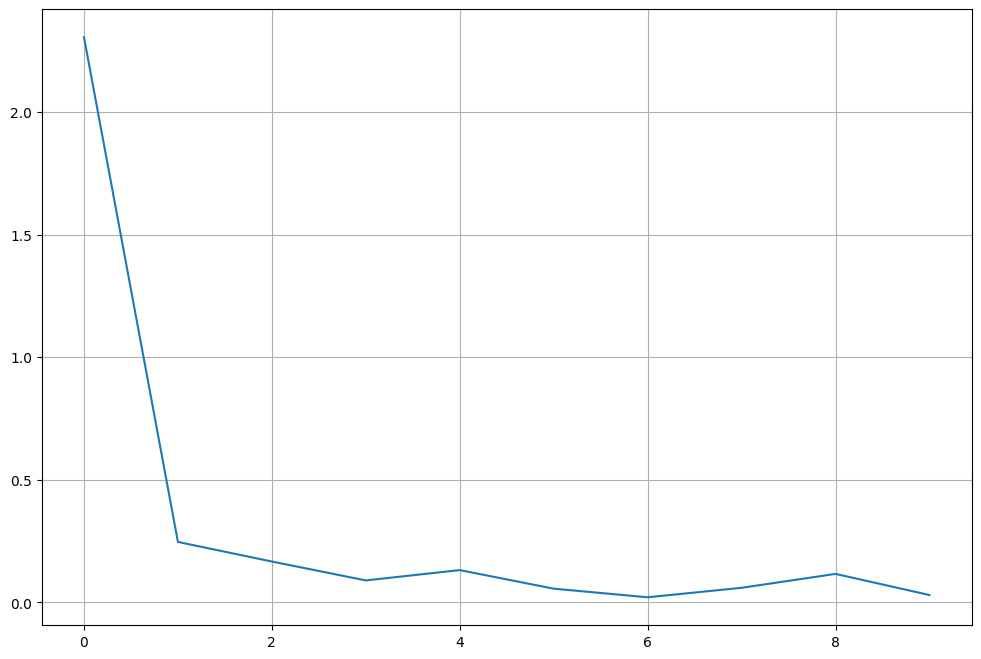

In [15]:
plt.figure(figsize=(12,8))
plt.plot(loss_arr)
plt.grid(True)
plt.show()

##### 테스트 정확도

In [16]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y_= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        
        # https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _,output_index = torch.max(output,1)
        
        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (output_index == y_).sum().float()
    
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 98.93830108642578%
